In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Funcs

In [2]:
# Loss function
# C: confidence matrix
# P: binary rating matrix
# X: user latent matrix
# Y: item latent matrix
# r_lambda: regularization lambda
# xTy: predict matrix
# total_loss = (confidence_level * predict loss) + regularization loss
def loss_function(C, P, xTy, X, Y, r_lambda):
    predict_error = np.square(P - xTy)
    confidence_error = np.sum(C * predict_error)
    regularization = r_lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_error + regularization
    return np.sum(predict_error), confidence_error, regularization, total_loss


# optimization function
# X[u] = (yTCuy + lambda*I)^-1yTCuy
# Y[i] = (xTCix + lambda*I)^-1xTCix
def optimize_user(X, Y, C, P, nu, nf, r_lambda):
    yT = np.transpose(Y)
    for u in range(nu):
        Cu = np.diag(C[u])
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)
        lI = np.dot(r_lambda, np.identity(nf))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)

def optimize_item(X, Y, C, P, ni, nf, r_lambda):
    xT = np.transpose(X)
    for i in range(ni):
        Ci = np.diag(C[:, i])
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)
        lI = np.dot(r_lambda, np.identity(nf))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

## Preps

In [3]:
cols = ['goods_id', 'user_id', 'rating', 'ts']
df = pd.read_csv('All_Beauty.csv', names = cols).head(1000) # take sample as an example

In [24]:
# r_lambda: normalization parameter
# alpha: confidence level
# nf: dimension of latent vector of each user and item
# initilzed values(40, 200, 40) are the best parameters from the paper

r_lambda = 50
nf = int(df.shape[0] / 10)
alpha = 50

In [25]:
# sample rating matrix
# make sample (user x items) matrix
# shape[0] : num of users
# shape[1] : num of items



R = pd.crosstab(index=df['user_id'],
                columns=df['goods_id'],
                values=df['rating'],
                aggfunc='mean').fillna(0).values

print(R.shape)

(1000, 4)


In [26]:
# latent factor matrix
# nu: num of users (10)
# ni: num of items (11)
# nf: dimension of latent vector

nu = R.shape[0]
ni = R.shape[1]

# initialize X and Y with very small values
X = np.random.rand(nu, nf) * 0.01
Y = np.random.rand(ni, nf) * 0.01

print(X)

[[0.00721528 0.0093024  0.00210475 ... 0.0073218  0.00313148 0.00793186]
 [0.00397356 0.00310381 0.00401414 ... 0.00496681 0.00909834 0.00088446]
 [0.00869955 0.00457017 0.0030019  ... 0.00809584 0.00269439 0.003514  ]
 ...
 [0.00906954 0.00082099 0.00532161 ... 0.00322984 0.00044348 0.00972044]
 [0.00198949 0.00197912 0.00156645 ... 0.00114036 0.0057294  0.00973398]
 [0.00316959 0.00815478 0.00616094 ... 0.00318607 0.00942281 0.00709028]]


In [27]:
# create binary raing matrix (convert original rating matrix R)
# Pui = 1 if Rui > 0
# Pui = 0 if Rui = 0

P = np.copy(R)
P[P > 0] = 1
print(P)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [28]:
# initialize confidence matrix C
# Cui = 1 + alpha * Rui
# Cui means confidence level of certain rating data


C = 1 + alpha * R
print(C)

[[  1.   1.   1. 251.]
 [  1.   1.   1. 251.]
 [  1.   1.   1. 251.]
 ...
 [  1.   1.   1. 251.]
 [  1.   1.   1. 251.]
 [  1.   1.   1. 251.]]


## Train

In [29]:
# in average ALS algorithm repeat train steps for 10 - 15 times

predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(15):
    if i!=0:   
        optimize_user(X, Y, C, P, nu, nf, r_lambda)
        optimize_item(X, Y, C, P, ni, nf, r_lambda)
    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C, P, predict, X, Y, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: %f" % confidence_error)
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)
    
predict = np.matmul(X, np.transpose(Y))
print('final predict')
print([predict])

----------------step 0----------------
predict error: 995.148428
confidence error: 233755.990118
regularization: 167.121228
total loss: 233923.111346
----------------step 1----------------
predict error: 292.764627
confidence error: 3850.053780
regularization: 5028.817665
total loss: 8878.871445
----------------step 2----------------
predict error: 21.741009
confidence error: 166.103482
regularization: 5050.805578
total loss: 5216.909060
----------------step 3----------------
predict error: 3.723549
confidence error: 96.321313
regularization: 4923.533921
total loss: 5019.855234
----------------step 4----------------
predict error: 1.970742
confidence error: 74.744762
regularization: 4836.051468
total loss: 4910.796231
----------------step 5----------------
predict error: 1.389497
confidence error: 64.104931
regularization: 4767.122823
total loss: 4831.227754
----------------step 6----------------
predict error: 1.051427
confidence error: 58.100574
regularization: 4708.210337
total loss

## Viz

<Figure size 432x288 with 0 Axes>

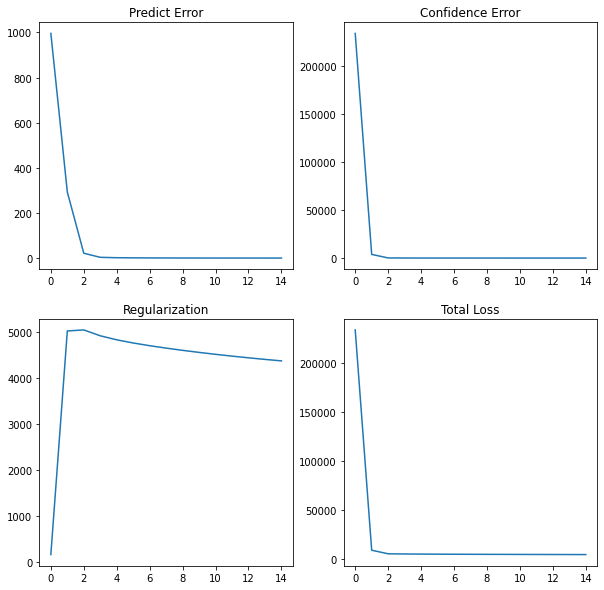

In [30]:
plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()